In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/efficientnet_mcs.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/Segmented/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/Segmented/val'
TEST_IMAGE_FOLDER = '/home/TBX11K/test'
SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

### EfficientNet Model

In [3]:
#load pretrained efficientnet model fine-tuned on our dataset
from tensorflow import keras
base_model = keras.models.load_model('./weights/efficientnet_segmented.hdf5')
features = base_model.layers[-3].output
batch_norm = tf.keras.layers.Dropout(0.4)(features)
y = tf.keras.layers.Dense(3, activation="softmax", kernel_initializer="he_normal")(batch_norm)
eff_model = tf.keras.Model(inputs=base_model.input, outputs=y)

for layer in base_model.layers:
    layer.trainable=False
    
eff_model.summary()

2022-08-28 04:24:19.350540: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-28 04:24:19.350621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13544 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0]']      

#### Keras Callbacks

In [4]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(eff_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(eff_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.3,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    brightness_range = [0.75, 1.25],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 7566 images belonging to 3 classes.
Found 1551 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.7479240806642942, 1: 0.8135483870967742, 2: 2.3053016453382082}
samples for train class labels: dict_items([(0, 3372), (1, 3100), (2, 1094)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 702), (1, 600), (2, 249)])


#### EfficientNet Compilation and Execution

In [8]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
eff_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [9]:
warnings.filterwarnings("ignore")
epochs = 20
history = eff_model.fit(train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=validation_generator, 
                                epochs=epochs,
                                verbose = 1,
                                class_weight = class_weights,
                                callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  0.001
Epoch 1/20


2022-08-28 04:24:50.151774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


237/237 [==============================] - ETA: 0s - loss: 0.2088 - accuracy: 0.9262 - AUC: 0.9893 - precision: 0.9418 - recall: 0.9096
Epoch 00001: val_loss improved from inf to 0.30921, saving model to ./weights/efficientnet_mcs.hdf5
End of epoch 0. Learning rate: 0.001
237/237 [==============================] - 108s 426ms/step - loss: 0.2088 - accuracy: 0.9262 - AUC: 0.9893 - precision: 0.9418 - recall: 0.9096 - val_loss: 0.3092 - val_accuracy: 0.8582 - val_AUC: 0.9730 - val_precision: 0.8637 - val_recall: 0.8536 - lr: 0.0010
Learning rate:  0.001
Epoch 2/20
237/237 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.9527 - AUC: 0.9945 - precision: 0.9557 - recall: 0.9500
Epoch 00002: val_loss improved from 0.30921 to 0.22356, saving model to ./weights/efficientnet_mcs.hdf5
End of epoch 1. Learning rate: 0.001
237/237 [==============================] - 102s 428ms/step - loss: 0.1417 - accuracy: 0.9527 - AUC: 0.9945 - precision: 0.9557 - recall: 0.9500 - val_loss:

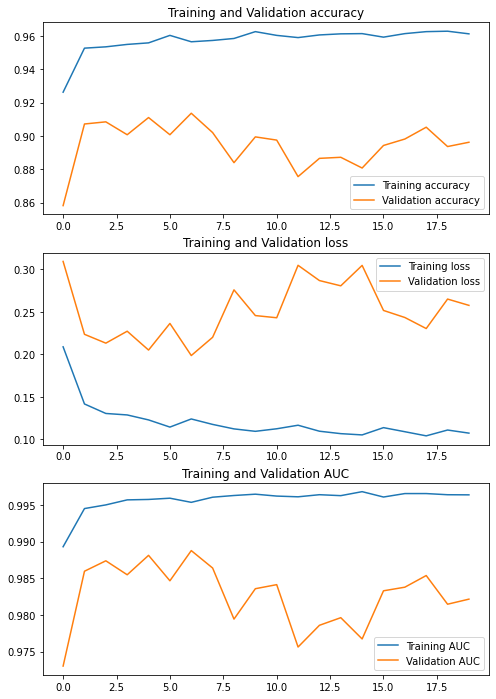

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [11]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
6,0.124063,0.956516,0.995344,0.959617,0.954798,0.198602,0.913604,0.988764,0.917701,0.905867,0.001000
4,0.122951,0.955855,0.995738,0.958920,0.953344,0.205042,0.911025,0.988118,0.913804,0.909091,0.001000
2,0.130530,0.953476,0.994995,0.957563,0.951361,0.213164,0.908446,0.987374,0.913950,0.903933,0.001000
7,0.117660,0.957309,0.996043,0.960000,0.954798,0.220047,0.901999,0.986389,0.907082,0.900064,0.001000
1,0.141693,0.952683,0.994495,0.955724,0.950040,0.223556,0.907157,0.985953,0.911880,0.900709,0.001000
3,0.128794,0.954930,0.995679,0.957574,0.951626,0.227192,0.900709,0.985470,0.907311,0.896196,0.001000
17,0.104218,0.962596,0.996539,0.965087,0.960878,0.230337,0.905222,0.985364,0.909091,0.902643,0.000316
5,0.114516,0.960349,0.995908,0.961916,0.958102,0.236311,0.900709,0.984650,0.906433,0.899420,0.001000
10,0.112533,0.960349,0.996196,0.962845,0.959027,0.243006,0.897485,0.984123,0.900520,0.892972,0.001000


#### EfficientNet Fine tuning

In [12]:
for layer in eff_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

        
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

history_finetune = eff_model.fit(train_generator,
                            epochs=30,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 20/30
237/237 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9531 - AUC: 0.9944 - precision: 0.9556 - recall: 0.9510
Epoch 00020: val_loss did not improve from 0.19860
End of epoch 19. Learning rate: 1e-04
237/237 [==============================] - 113s 445ms/step - loss: 0.1262 - accuracy: 0.9531 - AUC: 0.9944 - precision: 0.9556 - recall: 0.9510 - val_loss: 0.4277 - val_accuracy: 0.8291 - val_AUC: 0.9537 - val_precision: 0.8380 - val_recall: 0.8169 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 21/30
237/237 [==============================] - ETA: 0s - loss: 0.1138 - accuracy: 0.9570 - AUC: 0.9956 - precision: 0.9596 - recall: 0.9541
Epoch 00021: val_loss did not improve from 0.19860
End of epoch 20. Learning rate: 1e-04
237/237 [==============================] - 106s 445ms/step - loss: 0.1138 - accuracy: 0.9570 - AUC: 0.9956 - precision: 0.9596 - recall: 0.9541 - val_loss: 0.3221 - val_accuracy: 0.8743 - val_AUC: 

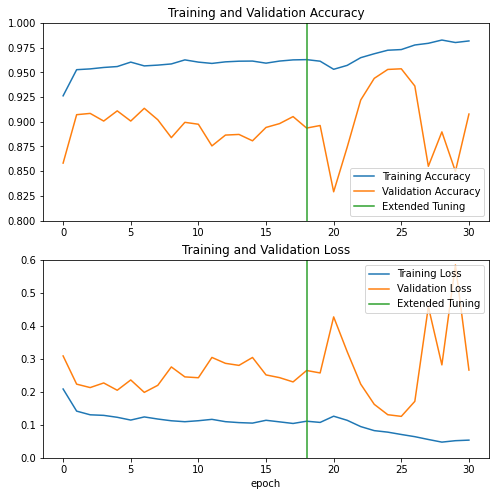

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Extended Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.6])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Extended Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
5,0.070775,0.973037,0.997914,0.973911,0.971980,0.125740,0.953578,0.994460,0.955398,0.952934,0.0001
4,0.077867,0.972376,0.997885,0.973120,0.971319,0.130783,0.952934,0.993814,0.955398,0.952934,0.0001
3,0.082480,0.968808,0.997752,0.970815,0.967222,0.162319,0.943907,0.992057,0.945525,0.940039,0.0001
6,0.064107,0.977663,0.998439,0.978408,0.976209,0.171324,0.936170,0.991439,0.936570,0.932947,0.0001
2,0.094731,0.964843,0.996788,0.966967,0.963389,0.223606,0.921986,0.985075,0.924724,0.918762,0.0001
10,0.053650,0.981761,0.998498,0.981874,0.980835,0.266315,0.907801,0.980677,0.909502,0.907157,0.0001
8,0.047593,0.982686,0.999287,0.983190,0.981761,0.281999,0.889749,0.978554,0.896349,0.886525,0.0001
1,0.113798,0.957045,0.995602,0.959591,0.954137,0.322100,0.874275,0.972417,0.884868,0.867182,0.0001
0,0.126250,0.953080,0.994441,0.955638,0.950965,0.427698,0.829143,0.953664,0.837963,0.816892,0.0001


In [15]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
eff_model.compile(
    optimizer=adam_optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history_finetune3 = eff_model.fit(train_generator,
                            epochs=45,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-05
Epoch 30/45
237/237 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9906 - AUC: 0.9997 - precision: 0.9910 - recall: 0.9904
Epoch 00030: val_loss did not improve from 0.12574
End of epoch 29. Learning rate: 1e-05
237/237 [==============================] - 113s 447ms/step - loss: 0.0282 - accuracy: 0.9906 - AUC: 0.9997 - precision: 0.9910 - recall: 0.9904 - val_loss: 0.2242 - val_accuracy: 0.9336 - val_AUC: 0.9861 - val_precision: 0.9347 - val_recall: 0.9323 - lr: 1.0000e-05
Learning rate:  1e-05
Epoch 31/45
237/237 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9922 - AUC: 0.9999 - precision: 0.9922 - recall: 0.9918
Epoch 00031: val_loss did not improve from 0.12574
End of epoch 30. Learning rate: 1e-05
237/237 [==============================] - 106s 445ms/step - loss: 0.0210 - accuracy: 0.9922 - AUC: 0.9999 - precision: 0.9922 - recall: 0.9918 - val_loss: 0.2132 - val_accuracy: 0.9381 - val_AUC: 

In [16]:
initial_epochs=history.epoch[-1]
tuning_2 = history_finetune.epoch[-1]

acc += history_finetune3.history['accuracy']
val_acc += history_finetune3.history['val_accuracy']
loss += history_finetune3.history['loss']
val_loss += history_finetune3.history['val_loss']

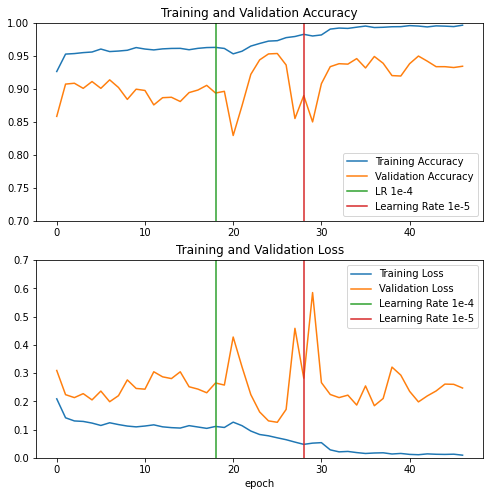

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='LR 1e-4')
plt.plot([tuning_2-1,tuning_2-1],
         plt.ylim(), label='Learning Rate 1e-5')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.7])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Learning Rate 1e-4')
plt.plot([tuning_2-1,tuning_2-1],
         plt.ylim(), label='Learning Rate 1e-5')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Montgomery County Dataset Evaluation

In [25]:
TEST_IMAGE_FOLDER = '/home/TBX11K/Segmented/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

model = tf.keras.models.load_model('./weights/efficientnet_mcs.hdf5')
res = model.predict(test_generator)

Found 28 images belonging to 3 classes.


In [26]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7500    0.9375    0.8333        16
           2     0.8750    0.5833    0.7000        12

    accuracy                         0.7857        28
   macro avg     0.8125    0.7604    0.7667        28
weighted avg     0.8036    0.7857    0.7762        28



#### Shenzhen Dataset Evaluation

In [27]:
TEST_IMAGE_FOLDER = '/home/TBX11K/Segmented/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 134 images belonging to 3 classes.


In [28]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted,digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9206    0.8788    0.8992        66
           2     0.8873    0.9265    0.9065        68

    accuracy                         0.9030       134
   macro avg     0.9040    0.9026    0.9028       134
weighted avg     0.9037    0.9030    0.9029       134



In [29]:
tf.keras.backend.clear_session()